In [136]:
import numpy as np
from scipy.stats import norm, t
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.stats import t as student_t


In [137]:
# Step 1: Define parameters
n_samples = 10000  # Number of simulations
n_assets = 50      # Number of assets
tau = 0.4          # Kendall's tau
std_dev = 0.01     # Standard deviation of each asset's returns
degrees_of_freedom = 3  # Degrees of freedom for t-distribution

# Convert Kendall's tau to Pearson correlation
rho = np.sin(np.pi * tau / 2)

# Step 2: Create the correlation matrix
correlation_matrix = np.full((n_assets, n_assets), rho)
np.fill_diagonal(correlation_matrix, 1)  # Diagonal elements are 1 (self-correlation)

VaR(0.01): -32942.16057919795, ES(0.01): -46673.96933404685


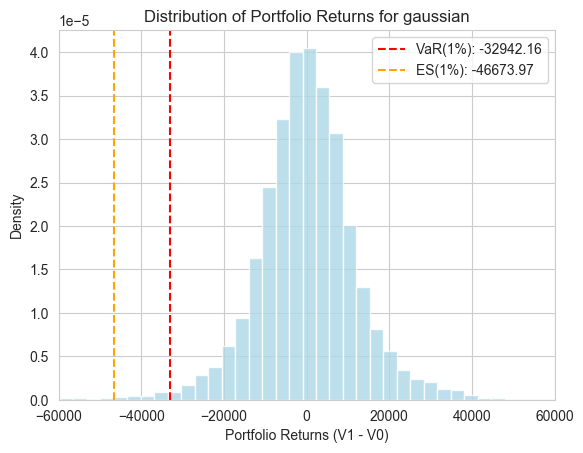

In [138]:
# Step 3: Generate samples from a multivariate normal distribution
L = cholesky(correlation_matrix, lower=True)  # Cholesky decomposition
z = np.random.normal(size=(n_samples, n_assets))
z_correlated = z @ L.T

# Step 4: Transform to uniform margins
u = norm.cdf(z_correlated)
# Step 5: Transform to t-margins
t_samples = t.ppf(u, df=degrees_of_freedom) * std_dev

# Step 6: Calculate portfolio value today and tomorrow
V0 = 50 * 20000  # Initial portfolio value (50 assets, each $20,000)
P1 = 20000 * np.exp(t_samples)  # Price tomorrow for each asset
V1 = np.sum(P1, axis=1)  # Portfolio value tomorrow

alpha = 0.01  # Tail probability (1%)
VaR_01 = np.percentile(V1 - V0, alpha * 100)
ES_01 = np.mean((V1 - V0)[(V1 - V0) <= VaR_01])
print(f"VaR(0.01): {VaR_01}, ES(0.01): {ES_01}")

# Compute portfolio returns
portfolio_returns = V1 - V0

# Plot the distribution of portfolio returns
plt.hist(portfolio_returns, bins=100, density=True, alpha=0.8, color='lightblue')
plt.axvline(VaR_01, color='red', linestyle='--', label=f'VaR(1%): {VaR_01:.2f}')
plt.axvline(ES_01, color='orange', linestyle='--', label=f'ES(1%): {ES_01:.2f}')
plt.title('Distribution of Portfolio Returns for gaussian')
plt.xlabel('Portfolio Returns (V1 - V0)')
plt.ylabel('Density')
plt.xlim(-60000,60000)
plt.legend()
plt.show()

VaR(0.01): -30661.286366700493, ES(0.01): -45276.93212002907


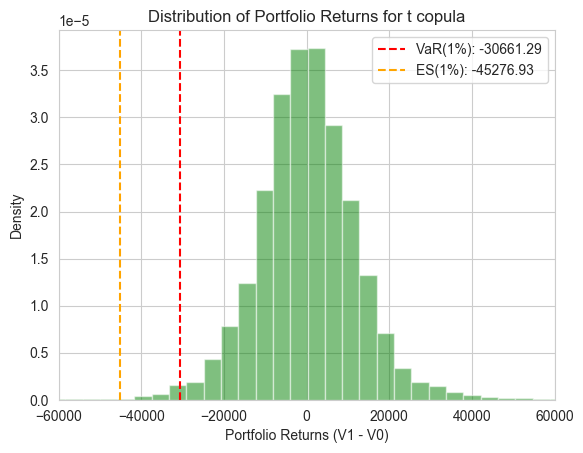

In [139]:
z_t = np.random.standard_t(df=4, size=(n_samples, n_assets))  # Independent t-samples
z_correlated_t = z_t @ L.T  # Introduce correlation

# Step 4: Transform to uniform margins (CDF of t-distribution with df=4)
u_t = student_t.cdf(z_correlated_t, df=4)

# Step 5: Transform to t-margins with df=4
t4_copula_samples = t.ppf(u_t, df=3) * std_dev

# Step 6: Calculate portfolio value today and tomorrow for the t-copula with df=4
P1_t_copula = 20000 * np.exp(t4_copula_samples)  # Price tomorrow for each asset
V1_t_copula = np.sum(P1_t_copula, axis=1)  # Portfolio value tomorrow

VaR_01_t = np.percentile(V1_t_copula - V0, alpha * 100)
ES_01_t = np.mean((V1_t_copula - V0)[(V1_t_copula - V0) <= VaR_01_t])
print(f"VaR(0.01): {VaR_01_t}, ES(0.01): {ES_01_t}")

# Compute portfolio returns
portfolio_returns_t = V1_t_copula - V0

# Plot the distribution of portfolio returns
plt.hist(portfolio_returns_t, bins=100, density=True, alpha=0.5, color='green')
plt.axvline(VaR_01_t, color='red', linestyle='--', label=f'VaR(1%): {VaR_01_t:.2f}')
plt.axvline(ES_01_t, color='orange', linestyle='--', label=f'ES(1%): {ES_01_t:.2f}')
plt.title('Distribution of Portfolio Returns for t copula')
plt.xlabel('Portfolio Returns (V1 - V0)')
plt.ylabel('Density')
plt.xlim(-60000,60000)
plt.legend()
plt.show()

VaR(0.01): 15815.40144506274, ES(0.01): 2996.80323582836


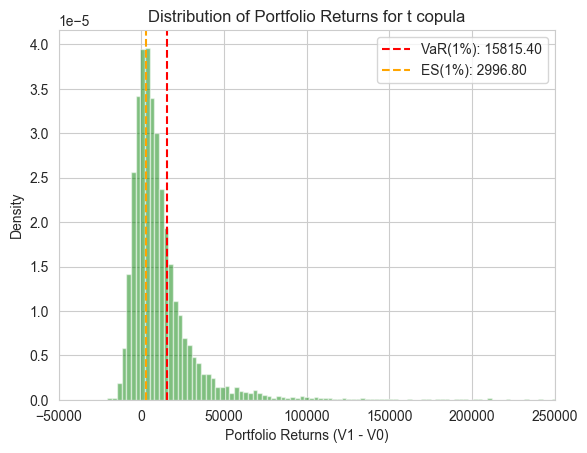

In [140]:
# Step 1: Sample W from a Gamma distribution
theta_clayton=2*tau/(1-tau)
alpha = 1 / theta_clayton  # Shape parameter for Gamma
W = np.random.gamma(alpha, 1, size=n_samples)  # Gamma-distributed random variable

# Step 2: Generate independent uniform samples
U_indep = np.random.uniform(size=(n_samples, n_assets))

# Step 3: Apply Clayton copula transformation
# Use the inverse generator function for Clayton copula to introduce dependence
clayton_uniform_revised = (1 + W[:, None] * (U_indep ** (-theta_clayton) - 1)) ** (-1 / theta_clayton)

# Ensure values are within [0, 1] due to numerical precision issues
clayton_uniform = np.clip(clayton_uniform_revised, 1e-10, 1 - 1e-10)

# Step 4: Transform to marginals (t-distribution with df=3 for log-returns)
t3_clayton_samples = t.ppf(clayton_uniform, df=3) * std_dev

# Step 5: Calculate portfolio value today and tomorrow for the revised Clayton copula
P1_clayton = 20000 * np.exp(t3_clayton_samples)  # Price tomorrow for each asset
V1_clayton = np.sum(P1_clayton, axis=1)  # Portfolio value tomorrow

VaR_01_clayton = np.percentile(V1_clayton - V0, alpha * 100)
ES_01_clayton = np.mean((V1_clayton - V0)[(V1_clayton - V0) <= VaR_01_clayton])
print(f"VaR(0.01): {VaR_01_clayton}, ES(0.01): {ES_01_clayton}")

# Compute portfolio returns
portfolio_returns_clayton = V1_clayton - V0

# Plot the distribution of portfolio returns
plt.hist(portfolio_returns_clayton, bins=1000, density=True, alpha=0.5, color='green')
plt.axvline(VaR_01_clayton, color='red', linestyle='--', label=f'VaR(1%): {VaR_01_clayton:.2f}')
plt.axvline(ES_01_clayton, color='orange', linestyle='--', label=f'ES(1%): {ES_01_clayton:.2f}')
plt.title('Distribution of Portfolio Returns for t copula')
plt.xlabel('Portfolio Returns (V1 - V0)')
plt.ylabel('Density')
plt.legend()
plt.xlim(-50000,250000)
plt.show()

